In [2]:
import os
import datasets
import transformers
import torch
from datasets import load_dataset
from datasets import DatasetDict, Dataset
from sklearn.model_selection import train_test_split

c:\Users\Bidhan\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [4]:
datasets.__version__, transformers.__version__, torch.__version__

('3.3.2', '4.49.0', '2.5.1')

# 1. Loading Dataset

In [5]:
ds = load_dataset("nicholasKluge/toxic-text")
ds

DatasetDict({
    portuguese: Dataset({
        features: ['non_toxic', 'toxic'],
        num_rows: 28103
    })
    english: Dataset({
        features: ['non_toxic', 'toxic'],
        num_rows: 41843
    })
})

In [6]:
# taking only the english dataset
ds = DatasetDict({
    "english": ds["english"]
})
ds

DatasetDict({
    english: Dataset({
        features: ['non_toxic', 'toxic'],
        num_rows: 41843
    })
})

In [7]:
def preprocess(batch):
    texts = []
    labels = []
    
    for non_toxic, toxic in zip(batch["non_toxic"], batch["toxic"]):
        if non_toxic:
            texts.append(non_toxic)
            labels.append('non_toxic')
        if toxic: 
            texts.append(toxic)
            labels.append('toxic')

    return {"text": texts, "label": labels}

# Apply preprocessing
processed_ds = ds["english"].map(preprocess, batched=True, remove_columns=["non_toxic", "toxic"])

In [8]:
processed_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 83686
})

In [9]:
processed_ds['text'][0], processed_ds['label'][0]

("Can you tell me how to keep my email password safe from being posted to the darkweb? Is this related to something you heard about recently? I'm guessing you mean that you're worried someone might get access to your email account and then find the password in there, or maybe intercept you while you're typing in your password, so that you can read it somehow. It's not really possible to keep passwords 100 % Thanks for the information. How do scammers find my email password on the darkweb? I'm confused by what you mean by “ darkweb ” and why you're asking me about this. It seems like you're saying that you know there's some type of site where scammers find email passwords? Yeah, do you know which websites scammer use to find people's email passwords? You mean to ask me whether there are any places online where someone can search to see email passwords?",
 'non_toxic')

In [10]:
processed_ds['text'][1], processed_ds['label'][1]

('Jenner has not been shy to offer her opinion on Hillary on the likely - to - be - cancelled I Am Cait, calling the candidate a “ fucking liar ” and a “ lousy senator. ”',
 'toxic')

In [11]:
# Convert the dataset to a format that can be used with sklearn (a pandas DataFrame)
df = processed_ds.to_pandas()

# First, split into train (80%) and test+validation (20%) with stratification
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Then, split test+validation into validation (50%) and test (50%) with stratification
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_ds = Dataset.from_pandas(train_df).remove_columns(['__index_level_0__'])
valid_ds = Dataset.from_pandas(valid_df).remove_columns(['__index_level_0__'])
test_ds = Dataset.from_pandas(test_df).remove_columns(['__index_level_0__'])

# Create final dataset dictionary
final_ds = DatasetDict({
    "train": train_ds,
    "validation": valid_ds,
    "test": test_ds
})

In [12]:
final_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 66948
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8369
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8369
    })
})

In [13]:
label2id = {'non_toxic': 0, 'toxic': 1}
id2label = {0: 'non_toxic', 1: 'toxic'}

# 2. Model and Tokenization

In [14]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

In [15]:
NUM_LABELS = len(label2id)

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = NUM_LABELS,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# 3. Preprocessing

In [16]:
def tokenize_function(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# Apply tokenization to train, validation, and test datasets
tokenized_ds = final_ds.map(tokenize_function, batched=True, remove_columns=["text"])

Map: 100%|██████████| 8369/8369 [00:00<00:00, 17022.09 examples/s]


In [17]:
# Apply label mapping
def map_labels(batch):
    batch['label'] = [label2id[label] for label in batch['label']]
    return batch

# Apply label mapping to dataset
tokenized_ds = tokenized_ds.map(map_labels, batched=True)

Map: 100%|██████████| 8369/8369 [00:00<00:00, 617951.73 examples/s]


In [18]:
tokenized_ds.set_format("torch")

In [19]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 66948
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8369
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8369
    })
})

In [20]:
tokenized_ds['train'][0]['input_ids'].shape

torch.Size([128])

In [21]:
tokenizer.decode(tokenized_ds['train'][0]['input_ids'])

'[CLS] fuck asshole fuck dirty fuckin asshole fuckin scum [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [22]:
tokenized_ds["train"]["label"]

tensor([1, 0, 1,  ..., 0, 1, 0])

# 4. Preparing dataloader

In [23]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
small_train_dataset = tokenized_ds["train"].shuffle(seed=SEED).select(range(10000))
small_eval_dataset = tokenized_ds["validation"].shuffle(seed=SEED).select(range(1000))
small_test_dataset = tokenized_ds["test"].shuffle(seed=SEED).select(range(1000))

In [25]:
from torch.utils.data import DataLoader

In [26]:
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [27]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

# 5. Design the model and losses

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [28]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non_toxic",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non_toxic": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [29]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()

In [30]:
num_hidden_layers = configuration['num_hidden_layers']

# indexing starts from 0 - so 0 to 11
# 1st layer = 0, 2nd layer = 1, ..., 12th layer = 11

# Even layers [1, 3, 5, 7, 9, 11]
even_layers = [i-1 for i in range(1, num_hidden_layers + 1) if i % 2 == 0]

# Odd layers [0, 2, 4, 6, 8, 10]
odd_layers = [i-1 for i in range(1, num_hidden_layers + 1) if i % 2 != 0]

# Even and odd layers count
even_count = num_hidden_layers // 2 # 6
odd_count = num_hidden_layers // 2 # 6

# Create configurations
configuration_even = configuration.copy()
configuration_even['num_hidden_layers'] = even_count

configuration_odd = configuration.copy()
configuration_odd['num_hidden_layers'] = odd_count

# Convert to BertConfig
configuration_even = BertConfig.from_dict(configuration_even)
configuration_odd = BertConfig.from_dict(configuration_odd)

In [31]:
model_even = type(teacher_model)(configuration_even)
model_even

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [32]:
model_odd = type(teacher_model)(configuration_odd)
model_odd

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [33]:
even_layers, odd_layers

([1, 3, 5, 7, 9, 11], [0, 2, 4, 6, 8, 10])

In [34]:
def copy_layers(teacher_model, student_model, selected_layers):
    student_dict = student_model.state_dict()
    teacher_dict = teacher_model.state_dict()

    for i, layer_idx in enumerate(selected_layers):
        teacher_layer_name = f'bert.encoder.layer.{layer_idx}'
        student_layer_name = f'bert.encoder.layer.{i}'
        
        for key in teacher_dict:
            if key.startswith(teacher_layer_name):
                new_key = key.replace(teacher_layer_name, student_layer_name)
                student_dict[new_key] = teacher_dict[key]
    
    student_model.load_state_dict(student_dict, strict=False)

# Copy even layers (2, 4, 6, ...)
copy_layers(teacher_model, model_even, even_layers)

# Copy odd layers (1, 3, 5, ...)
copy_layers(teacher_model, model_odd, odd_layers)

In [35]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher: Module,
    student: Module,
    selected_layers: list
) -> None:
    """
    Copies specific layers from the teacher model to the student model.

    Args:
        teacher (Module): The teacher model (pretrained BERT).
        student (Module): The student model (reduced BERT).
        selected_layers (list): Indices of teacher layers to copy.
    """
    # If the model is a full BERT model or a BertFor... model, iterate over its children
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, selected_layers)

    # If it's an encoder, copy only the specified layers
    elif isinstance(teacher, BertEncoder):
        teacher_layers = list(teacher.layer)  # Get teacher's transformer layers
        student_layers = list(student.layer)  # Get student's transformer layers

        if len(selected_layers) != len(student_layers):
            raise ValueError("Mismatch: Student model layers should match the selected teacher layers!")

        for student_layer, teacher_index in zip(student_layers, selected_layers):
            student_layer.load_state_dict(teacher_layers[teacher_index].state_dict())

    # Otherwise, copy the whole state_dict (for embeddings, output heads, etc.)
    else:
        student.load_state_dict(teacher.state_dict())

    return student  # Return the student model for confirmation


In [36]:
# Distill even layers (2, 4, 6, 8, 10, 12) -> [1, 3, 5, 7, 9, 11] in 0-based indexing
distill_bert_weights(teacher_model, model_even, even_layers)

# Distill odd layers (1, 3, 5, 7, 9, 11) -> [0, 2, 4, 6, 8, 10] in 0-based indexing
distill_bert_weights(teacher_model, model_odd, odd_layers)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model_even))

Teacher parameters : 109483778
Student parameters : 66956546


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model_odd))

Teacher parameters : 109483778
Student parameters : 66956546


In [39]:
print(f"even: {count_parameters(model_even)/count_parameters(teacher_model) * 100:.2f}%")
print(f"odd: {count_parameters(model_odd)/count_parameters(teacher_model) * 100:.2f}%")

even: 61.16%
odd: 61.16%


## Loss function

In [40]:
import torch.nn.functional as F
import torch.nn as nn

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [41]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

# 6. Optimizer

In [42]:
import torch.optim as optim

lr = 5e-5

#training hyperparameters
optimizer_even = optim.Adam(params=model_even.parameters(), lr=lr)
optimizer_odd = optim.Adam(params=model_odd.parameters(), lr=lr)

In [43]:
model_even = model_even.to(device)
model_odd = model_odd.to(device)
teacher_model = teacher_model.to(device)

# 7. Learning Rate Scheduler

In [44]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler_even = get_scheduler(
    name="linear", 
    optimizer=optimizer_even, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

lr_scheduler_odd = get_scheduler(
    name="linear", 
    optimizer=optimizer_odd, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

# 8. Metric

In [46]:
import numpy as np
import evaluate

# Get the metric function
metric = evaluate.load("accuracy")

# 9. Train

In [47]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

  0%|          | 0/1565 [00:00<?, ?it/s]

In [48]:
# Lists to store losses for each epoch
train_losses_even = []
train_losses_cls_even = []
train_losses_div_even = []
train_losses_cos_even = []
eval_losses_even = []

for epoch in range(num_epochs):
    model_even.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model_even(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_even.step()
        lr_scheduler_even.step()
        optimizer_even.zero_grad()
        progress_bar.update(1)
        
    train_losses_even.append(train_loss / len(train_dataloader))
    train_losses_cls_even.append(train_loss_cls / len(train_dataloader))
    train_losses_div_even.append(train_loss_div / len(train_dataloader))
    train_losses_cos_even.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model_even.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_even(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses_even.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

 20%|██        | 313/1565 [02:38<04:48,  4.35it/s] 

Epoch at 1: Train loss 0.2000:
  - Loss_cls: 0.4414
  - Loss_div: 0.0902
  - Loss_cos: 0.0684
Epoch at 1: Test Acc 0.9230


 40%|███▉      | 625/1565 [04:01<04:05,  3.82it/s]

Epoch at 2: Train loss 0.1787:
  - Loss_cls: 0.3533
  - Loss_div: 0.1217
  - Loss_cos: 0.0611
Epoch at 2: Test Acc 0.9340


 60%|█████▉    | 938/1565 [05:25<02:43,  3.83it/s]

Epoch at 3: Train loss 0.1710:
  - Loss_cls: 0.3244
  - Loss_div: 0.1318
  - Loss_cos: 0.0567
Epoch at 3: Test Acc 0.9470


 80%|███████▉  | 1251/1565 [06:49<01:22,  3.81it/s]

Epoch at 4: Train loss 0.1675:
  - Loss_cls: 0.3132
  - Loss_div: 0.1354
  - Loss_cos: 0.0538
Epoch at 4: Test Acc 0.9450


100%|█████████▉| 1564/1565 [08:12<00:00,  3.82it/s]

Epoch at 5: Train loss 0.1657:
  - Loss_cls: 0.3098
  - Loss_div: 0.1364
  - Loss_cos: 0.0510
Epoch at 5: Test Acc 0.9450
Avg Metric 0.9388


In [49]:
import matplotlib.pyplot as plt

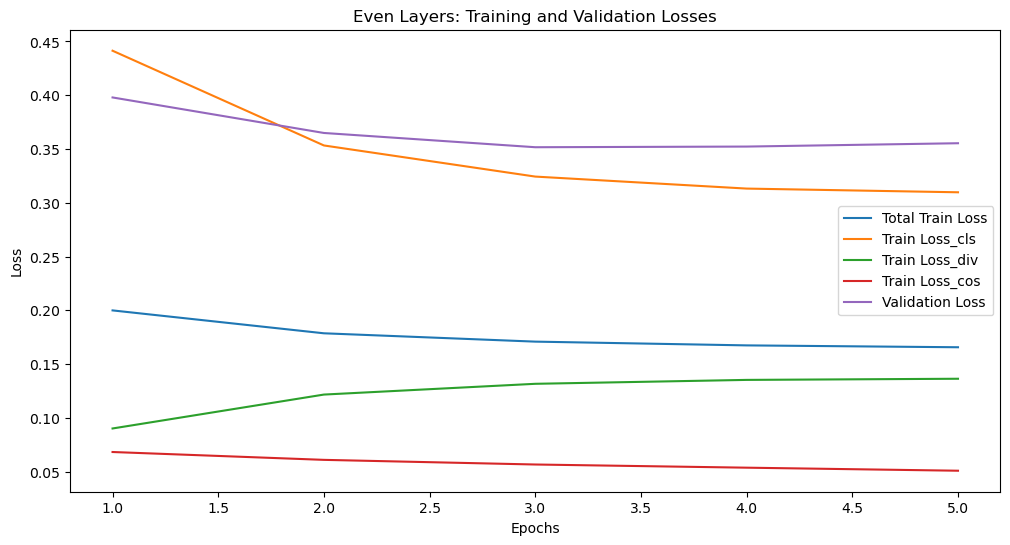

In [50]:
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_even, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_even, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_even, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_even, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_even, label='Validation Loss')

plt.title('Even Layers: Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
from tqdm.auto import tqdm
progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

 12%|█▏        | 195/1565 [02:36<18:21,  1.24it/s]


In [54]:
# Lists to store losses for each epoch
train_losses_odd = []
train_losses_cls_odd = []
train_losses_div_odd = []
train_losses_cos_odd = []
eval_losses_odd = []

for epoch in range(num_epochs):
    model_odd.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model_odd(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_odd.step()
        lr_scheduler_odd.step()
        optimizer_odd.zero_grad()
        progress_bar.update(1)
        
    train_losses_odd.append(train_loss / len(train_dataloader))
    train_losses_cls_odd.append(train_loss_cls / len(train_dataloader))
    train_losses_div_odd.append(train_loss_div / len(train_dataloader))
    train_losses_cos_odd.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model_odd.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_odd(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses_odd.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

 20%|█▉        | 312/1565 [01:22<05:29,  3.81it/s]

Epoch at 1: Train loss 0.1843:
  - Loss_cls: 0.3732
  - Loss_div: 0.1174
  - Loss_cos: 0.0623
Epoch at 1: Test Acc 0.9350


 40%|███▉      | 625/1565 [02:45<04:07,  3.80it/s]

Epoch at 2: Train loss 0.1734:
  - Loss_cls: 0.3317
  - Loss_div: 0.1303
  - Loss_cos: 0.0580
Epoch at 2: Test Acc 0.9410


 60%|█████▉    | 938/1565 [04:09<02:44,  3.82it/s]

Epoch at 3: Train loss 0.1690:
  - Loss_cls: 0.3157
  - Loss_div: 0.1360
  - Loss_cos: 0.0553
Epoch at 3: Test Acc 0.9420


 80%|███████▉  | 1251/1565 [05:33<01:22,  3.83it/s]

Epoch at 4: Train loss 0.1665:
  - Loss_cls: 0.3088
  - Loss_div: 0.1380
  - Loss_cos: 0.0526
Epoch at 4: Test Acc 0.9410


100%|█████████▉| 1564/1565 [06:56<00:00,  3.81it/s]

Epoch at 5: Train loss 0.1654:
  - Loss_cls: 0.3085
  - Loss_div: 0.1368
  - Loss_cos: 0.0510
Epoch at 5: Test Acc 0.9440
Avg Metric 0.9405999999999999


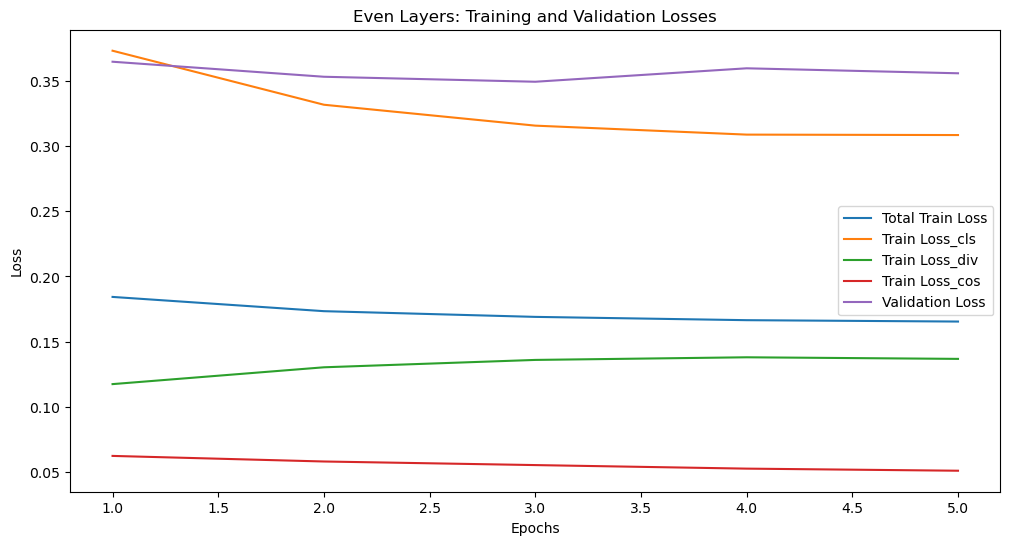

In [55]:
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_odd, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_odd, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_odd, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_odd, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_odd, label='Validation Loss')

plt.title('Even Layers: Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [58]:
y_true_even = []
y_pred_even = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        # Forward pass
        outputs = model_even(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Convert logits to predicted labels
        batch_predictions = torch.argmax(logits, dim=1)
        # Append true and predicted labels to lists
        y_true_even.extend(labels.cpu().numpy())
        y_pred_even.extend(batch_predictions.cpu().numpy())
# Compute evaluation metrics
accuracy_even = accuracy_score(y_true_even, y_pred_even)
precision_even = precision_score(y_true_even, y_pred_even, average='weighted')
recall_even = recall_score(y_true_even, y_pred_even, average='weighted')
f1_even = f1_score(y_true_even, y_pred_even, average='weighted')

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class ConfusionMatrixPlotter:
    def __init__(self, true_labels, predicted_labels, labels):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.labels = labels
    def plot(self):
        cm = confusion_matrix(self.true_labels, self.predicted_labels)
        plt.figure(figsize=(15, 5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.labels, yticklabels=self.labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

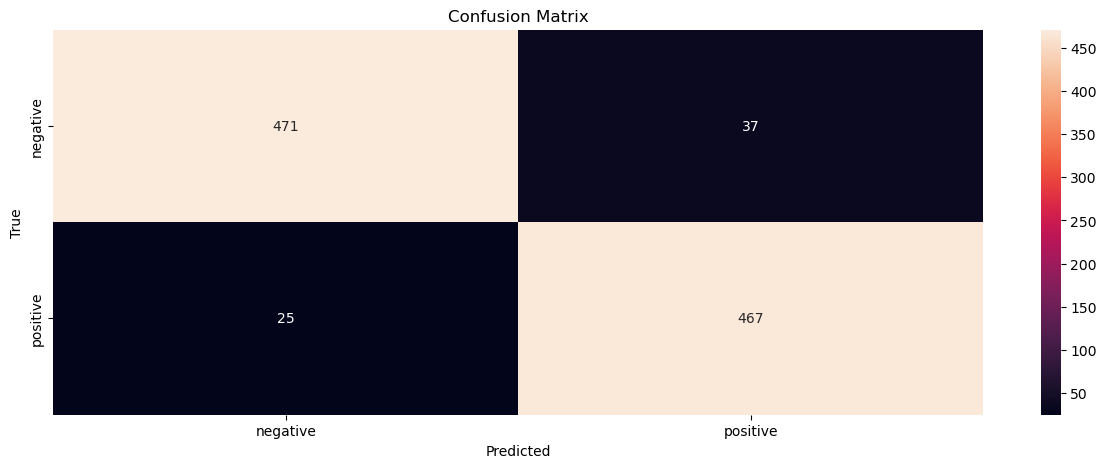

In [68]:
labels = ["negative", "positive"]
cm_plotter = ConfusionMatrixPlotter(y_true_even, y_pred_even, labels)
cm_plotter.plot()

In [62]:
print(f"Accuracy: {accuracy_even:.4f}")
print(f"Precision: {precision_even:.4f}")
print(f"Recall: {recall_even:.4f}")
print(f"F1: {f1_even:.4f}")

Accuracy: 0.9380
Precision: 0.9383
Recall: 0.9380
F1: 0.9380


In [63]:
y_true_odd = []
y_pred_odd = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        # Forward pass
        outputs = model_odd(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Convert logits to predicted labels
        batch_predictions = torch.argmax(logits, dim=1)
        # Append true and predicted labels to lists
        y_true_odd.extend(labels.cpu().numpy())
        y_pred_odd.extend(batch_predictions.cpu().numpy())
# Compute evaluation metrics
accuracy_odd = accuracy_score(y_true_odd, y_pred_odd)
precision_odd = precision_score(y_true_odd, y_pred_odd, average='weighted')
recall_odd = recall_score(y_true_odd, y_pred_odd, average='weighted')
f1_odd = f1_score(y_true_odd, y_pred_odd, average='weighted')

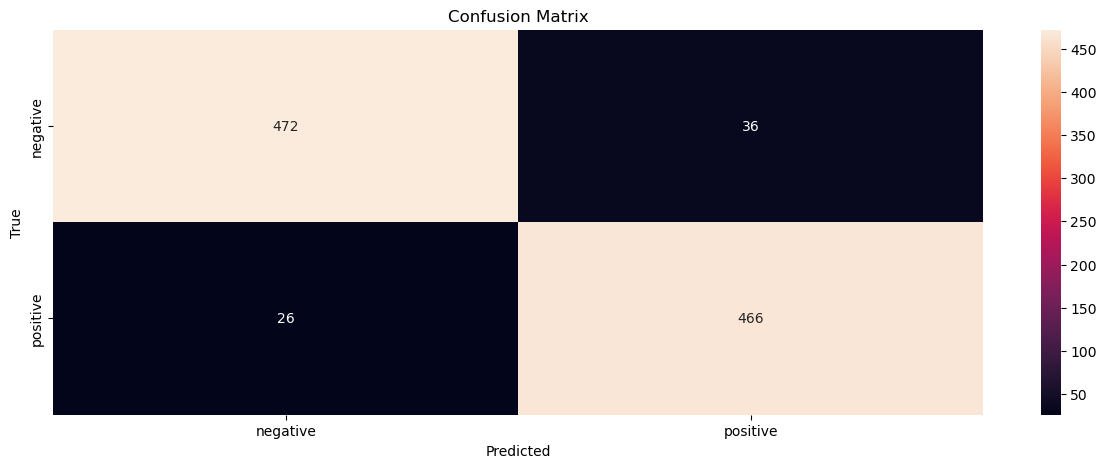

In [69]:
labels = ["negative", "positive"]
cm_plotter = ConfusionMatrixPlotter(y_true_odd, y_pred_odd, labels)
cm_plotter.plot()

In [65]:
print(f"Accuracy: {accuracy_odd:.4f}")
print(f"Precision: {precision_odd:.4f}")
print(f"Recall: {recall_odd:.4f}")
print(f"F1: {f1_odd:.4f}")

Accuracy: 0.9380
Precision: 0.9382
Recall: 0.9380
F1: 0.9380


In [ ]:
save_directory = "./model/trained_odd_model"

# Save the model
model_odd.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

save_directory = "./model/trained_even_model"
model_even.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./model/trained_even_model\\tokenizer_config.json',
 './model/trained_even_model\\special_tokens_map.json',
 './model/trained_even_model\\vocab.txt',
 './model/trained_even_model\\added_tokens.json',
 './model/trained_even_model\\tokenizer.json')

In [ ]:
# torch.save(model_even, 'model/model_even.pth')
# torch.save(model_odd, 'model/model_odd.pth')

# # save the tokenizer
# tokenizer.save_pretrained('model/')

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

# LoRA

In [70]:
from peft import LoraConfig, get_peft_model